In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_rel
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt




In [4]:
# Reading the Data and dropping 'ID'

df=pd.read_excel('TrainDataset2023.xls')
df=df.drop('ID',axis=1)


In [5]:
df.describe()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,400.000000,400.000000,400.000000,400.000000
mean,12.697500,56.000208,51.804674,0.547500,2.902500,2.797500,2.830000,9.875000,6.562500,8.63250,...,3.957637e-01,3.911005e-01,2.722189e+00,0.003347,5.679717e+07,178.311246,32500.032620,0.056935,0.005965,0.029322
std,111.107417,27.137584,10.948522,0.498362,49.932114,49.937068,49.935558,86.092911,70.444284,86.20034,...,1.666319e-01,1.615922e-01,7.648849e-01,0.002419,7.063846e+08,1045.453432,177545.921568,0.047179,0.008379,0.115915
min,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,...,7.050000e-11,7.050000e-11,-3.200000e-16,0.000008,0.000000e+00,0.000000,0.000248,0.000000,0.000000,0.000000
25%,0.000000,38.000000,44.516769,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.00000,...,3.199017e-01,3.184398e-01,2.340783e+00,0.001389,1.030473e+06,18.760570,0.001826,0.018628,0.000310,0.001464
50%,0.000000,55.000000,51.019507,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.00000,...,4.095627e-01,4.054695e-01,2.814884e+00,0.002944,3.277334e+06,67.929659,0.004383,0.047740,0.002330,0.003276
75%,0.000000,73.000000,60.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.00000,...,5.000049e-01,4.956920e-01,3.304411e+00,0.004798,9.079686e+06,157.370294,0.013769,0.085321,0.007962,0.009479
max,999.000000,144.000000,79.603012,1.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.00000,...,8.773779e-01,8.571429e-01,4.947427e+00,0.011301,1.390001e+10,20764.693790,1000000.000000,0.285100,0.060742,1.145601


pCR (outcome)
0    0.787342
1    0.212658
Name: proportion, dtype: float64

<Axes: xlabel='pCR (outcome)', ylabel='count'>

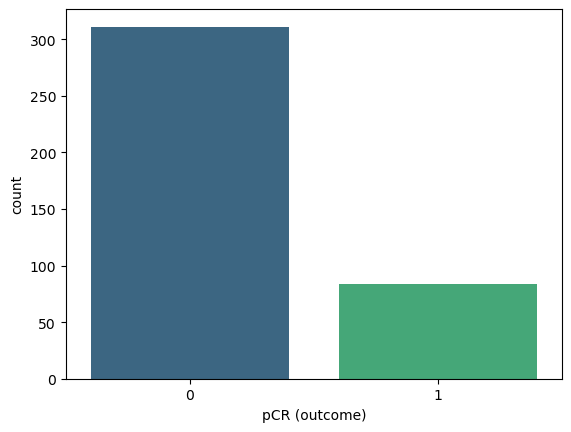

In [6]:
display(df['pCR (outcome)'][df['pCR (outcome)']!=999].value_counts(normalize=True))

sns.countplot(x='pCR (outcome)', data=df[['pCR (outcome)']][df['pCR (outcome)']!=999], palette='viridis')

In [7]:
# Counting Number of missing valaues in each feature
result = (df == 999).sum().sort_values(ascending=False)

# Display all rows of the resulting Series
with pd.option_context('display.max_rows', None):
    print(result)


pCR (outcome)                                         5
HistologyType                                         3
ChemoGrade                                            3
Proliferation                                         2
TrippleNegative                                       1
LNStatus                                              1
HER2                                                  1
PgR                                                   1
original_glrlm_LongRunLowGrayLevelEmphasis            0
original_glrlm_LowGrayLevelRunEmphasis                0
original_gldm_LargeDependenceLowGrayLevelEmphasis     0
original_glrlm_LongRunHighGrayLevelEmphasis           0
original_glrlm_LongRunEmphasis                        0
original_glrlm_HighGrayLevelRunEmphasis               0
original_glrlm_GrayLevelVariance                      0
original_glrlm_GrayLevelNonUniformityNormalized       0
original_glrlm_GrayLevelNonUniformity                 0
original_gldm_SmallDependenceLowGrayLevelEmphasi

In [8]:
# Dealing With missing values
def data_cleaning_for_classification(df):
    
    # dropping RelapseFreeSurvival for Classification
    
    df=df.drop('RelapseFreeSurvival (outcome)',axis=1)
    
    # Replacing missing values
    
    df=df.replace(999, np.nan)
    df=df.dropna(subset=['pCR (outcome)'])
    
    
    imputer = SimpleImputer(strategy='median')

    df_imputed=imputer.fit_transform(df)

    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Dealing with Categorical variables

    #  Age,ChemoGrade,Proliferation and TumorStage are ordinal categorical variables so we do not change them

    # ER, PGR, HER2, TrippleNegative, HistologyType and LNStatus are either binary or categorical variables with 2 different
    # values. We just convert HistologyType to binary format.

    df_imputed['HistologyType'] = df_imputed['HistologyType'].map({1: 0, 2: 1})
    
    return df_imputed





In [9]:
# Cleaning Dataset


df_cleaned=data_cleaning_for_classification(df)



In [10]:
# Defining Model(SVM) 
model = SVC(random_state=21)

In [55]:
# Normalizing, Oversampling and Hyperparameter Tuning for SVM
scaler = StandardScaler()
oversampler = SMOTE(random_state=21)
param_grid = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__degree': [2, 3, 4],  
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10],
    'svm__coef0': [0.0, 0.1, 0.5, 1.0],  
    'pca__n_components':[None, 0.95,0.9,0.85]}



outer_cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=25)
inner_cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=25)

X=df_cleaned.drop('pCR (outcome)',axis=1)
y=df_cleaned['pCR (outcome)']

scores=[]
# Nested Cross Validation
for train_outer_idx, test_outer_idx in outer_cv.split(X, y):
    X_train_outer, X_test_outer = X.iloc[train_outer_idx], X.iloc[test_outer_idx]
    y_train_outer, y_test_outer = y.iloc[train_outer_idx], y.iloc[test_outer_idx]
    
    
    X_resampled, y_resampled = oversampler.fit_resample(X_train_outer, y_train_outer)
    


    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),  
        ('svm', SVC(random_state=21))]) 

    # Hyperparameter Tuning using GridSearchCV 
    grid_search = RandomizedSearchCV(svm_pipeline, param_distributions=param_grid , scoring='accuracy', cv=inner_cv)
    grid_search.fit(X_resampled, y_resampled)

    # Best Hyperparameters
    best_params = grid_search.best_params_

    # Evaluation on the Test Set
    score = grid_search.score(X_test_outer, y_test_outer)
    scores.append(score)
    # Classification report
    best_model=grid_search.best_estimator_
    y_predict=best_model.predict(X_test_outer)
    
    cv_results = grid_search.cv_results_

    # printing the result
    print(cv_results['mean_test_score'])
    print(f"Accuracy: {score:.4f}, Best Hyperparameters: {best_params}")
    print(classification_report(y_test_outer, y_predict))

[0.55797101 0.71256039 0.54589372 0.52415459 0.49033816 0.68599034
 0.6352657  0.70289855 0.63285024 0.71256039]
Accuracy: 0.6212, Best Hyperparameters: {'svm__kernel': 'linear', 'svm__gamma': 0.001, 'svm__degree': 3, 'svm__coef0': 0.5, 'svm__C': 0.1, 'pca__n_components': 0.95}
              precision    recall  f1-score   support

         0.0       0.89      0.60      0.71       104
         1.0       0.32      0.71      0.44        28

    accuracy                           0.62       132
   macro avg       0.60      0.66      0.58       132
weighted avg       0.77      0.62      0.66       132

[0.74396135 0.52657005 0.70531401 0.58937198 0.50241546 0.50966184
 0.52173913 0.65942029 0.85024155 0.49275362]
Accuracy: 0.7727, Best Hyperparameters: {'svm__kernel': 'rbf', 'svm__gamma': 0.1, 'svm__degree': 2, 'svm__coef0': 0.5, 'svm__C': 10, 'pca__n_components': None}
              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87       104
         1.0

In [11]:
Macro_Averages_of_F1_Score_SVM=[0.43,0.56,0.51]

In [46]:
# Defining Model Random Forest
rf_classifier =RandomForestClassifier(random_state=21)

In [11]:
oversampler = SMOTE(random_state=21)
param_grid = {
    'rf__n_estimators': [50, 100, 200, 300],  
    'rf__max_depth': [None,1,3, 5, 10, 15], 
    'rf__min_samples_split': [2, 5, 10],  
    'rf__min_samples_leaf': [1, 2, 4]  ,
    'pca__n_components':[None, 0.95,0.9,0.85]
}

outer_cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=21)
inner_cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

X=df_cleaned.drop('pCR (outcome)',axis=1)
y=df_cleaned['pCR (outcome)']

scores=[]

for train_outer_idx, test_outer_idx in outer_cv.split(X, y):
    X_train_outer, X_test_outer = X.iloc[train_outer_idx], X.iloc[test_outer_idx]
    y_train_outer, y_test_outer = y.iloc[train_outer_idx], y.iloc[test_outer_idx]
    
    
    X_resampled, y_resampled = oversampler.fit_resample(X_train_outer, y_train_outer)
    
    rf_pipeline = Pipeline([
    
    ('pca', PCA()),  
    ('rf', RandomForestClassifier(random_state=21))]) 




    # Hyperparameter Tuning using GridSearchCV 
    grid_search = RandomizedSearchCV(rf_pipeline, param_distributions=param_grid , scoring='accuracy', cv=inner_cv)
    grid_search.fit(X_resampled, y_resampled)

    # Best Hyperparameters
    best_params = grid_search.best_params_

    # Evaluation on the Test Set
    score = grid_search.score(X_test_outer, y_test_outer)
    scores.append(score)
    # Classification report
    best_model=grid_search.best_estimator_
    y_predict=best_model.predict(X_test_outer)
    
    

    # printing the result
    print(f"Accuracy: {score:.4f}, Best Hyperparameters: {best_params}")
    print(classification_report(y_test_outer, y_predict))

Accuracy: 0.7652, Best Hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_depth': None, 'pca__n_components': None}
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.87       104
         1.0       0.00      0.00      0.00        28

    accuracy                           0.77       132
   macro avg       0.39      0.49      0.43       132
weighted avg       0.62      0.77      0.68       132

Accuracy: 0.7424, Best Hyperparameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': 1, 'pca__n_components': None}
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       104
         1.0       0.33      0.21      0.26        28

    accuracy                           0.74       132
   macro avg       0.57      0.55      0.55       132
weighted avg       0.71      0.74      0.72       132

Accurac

In [ ]:
Macro_Averages_of_F1_Score_RF=[0.43,0.49,0.47]

In [12]:
# Defining Model XGB
model = XGBClassifier()


In [49]:
# Normalizing, Oversampling and Hyperparameter Tuning for SVM

oversampler = SMOTE(random_state=21)
param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [1, 2, 3, 4, 5,6],
    'xgb__min_child_weight': [1,3, 5],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__gamma': [0, 0.1,0.2,0.3],
    'xgb__reg_alpha': [0, 0.1, 0.2, 0.3],
    'xgb__reg_lambda': [1, 1.1, 1.2, 1.3],
    'xgb__scale_pos_weight': [1, 2, 3]
     ,'pca__n_components':[None, 0.95,0.9,0.85,0.8]
}



outer_cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=22)
inner_cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=22)

X=df_cleaned.drop('pCR (outcome)',axis=1)
y=df_cleaned['pCR (outcome)']

scores=[]
# Nested Cross Validation
for train_outer_idx, test_outer_idx in outer_cv.split(X, y):
    X_train_outer, X_test_outer = X.iloc[train_outer_idx], X.iloc[test_outer_idx]
    y_train_outer, y_test_outer = y.iloc[train_outer_idx], y.iloc[test_outer_idx]
    
    
    X_resampled, y_resampled = oversampler.fit_resample(X_train_outer, y_train_outer)
    


    xgb_pipeline =Pipeline([
        ('pca', PCA()),
        ('xgb', XGBClassifier(random_state=21))
    ])

    # Hyperparameter Tuning using GridSearchCV 
    grid_search = RandomizedSearchCV(xgb_pipeline, param_distributions=param_grid , scoring='accuracy', cv=inner_cv)
    grid_search.fit(X_resampled, y_resampled)

    # Best Hyperparameters
    best_params = grid_search.best_params_

    # Evaluation on the Test Set
    score = grid_search.score(X_test_outer, y_test_outer)
    scores.append(score)
    # Classification report
    best_model=grid_search.best_estimator_
    y_predict=best_model.predict(X_test_outer)
    
    

    # printing the result
    print(f"Accuracy: {score:.4f}, Best Hyperparameters: {best_params}")
    print(classification_report(y_test_outer, y_predict))

Accuracy: 0.7121, Best Hyperparameters: {'xgb__subsample': 0.9, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 1.2, 'xgb__reg_alpha': 0.3, 'xgb__n_estimators': 100, 'xgb__min_child_weight': 5, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.2, 'xgb__colsample_bytree': 0.8, 'pca__n_components': None}
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       104
         1.0       0.19      0.11      0.14        28

    accuracy                           0.71       132
   macro avg       0.49      0.49      0.48       132
weighted avg       0.66      0.71      0.68       132

Accuracy: 0.6742, Best Hyperparameters: {'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.3, 'xgb__n_estimators': 200, 'xgb__min_child_weight': 3, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.8, 'pca__n_components': None}
              precision    recall  f1-sco

In [ ]:
Macro_Averages_of_F1_Score_XGBoost =[0.54,0.55,0.48]

In [ ]:
# Comparing RF and XGB based on t-test

In [26]:
xgb=XGBClassifier(subsample= 0.9, scale_pos_weight= 2, reg_lambda= 1.1, reg_alpha= 0,\
                  n_estimators= 100, min_child_weight= 1, max_depth= 5, learning_rate= 0.2,\
                  gamma= 0.1, colsample_bytree= 1.0)

rf=RandomForestClassifier(n_estimators= 300, min_samples_split= 5, min_samples_leaf= 1, max_depth= 15)


xgb_scores=[]
rf_scores=[]


for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=np.random.randint(1,1000))

    
    X_resampled, y_resampled=oversampler.fit_resample(X_train, y_train)
    xgb.fit(X_resampled, y_resampled)
    rf.fit(X_resampled, y_resampled)
    
    
    X_test_resampled, y_test_resampled=oversampler.fit_resample(X_test, y_test)
    
    y_predict_xgb=xgb.predict(X_test_resampled)
    y_predict_rf=rf.predict(X_test_resampled)
    
    
    xgb_scores.append(accuracy_score(y_test_resampled, y_predict_xgb))
    rf_scores.append(accuracy_score(y_test_resampled, y_predict_rf))
    
    
    
    
    

In [78]:
t_stat, p_value = ttest_rel(xgb_scores, rf_scores)
print(p_value)
print(np.mean(xgb_scores))
print(np.mean(rf_scores))

0.0003899259978717992
0.7650280205118688
0.703481081189866


In [75]:
# Comparing SVC and XGB based on t-test
xgb=XGBClassifier(subsample= 0.9, scale_pos_weight= 2, reg_lambda= 1.1, reg_alpha= 0,\
                  n_estimators= 100, min_child_weight= 1, max_depth= 5, learning_rate= 0.2,\
                  gamma= 0.1, colsample_bytree= 1.0)

svm=SVC(kernel= 'poly',  degree= 3,  C= 0.01,coef0= 1.0)
pca=PCA(n_components=0.85)
scaler=StandardScaler()


xgb_scores=[]
svc_scores=[]


for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=np.random.randint(1,1000))

    
    X_resampled, y_resampled=oversampler.fit_resample(X_train, y_train)
    xgb.fit(X_resampled, y_resampled)
    
    X_resampled_scaled=scaler.fit_transform(X_resampled)
    X_resampled_pca=pca.fit_transform(X_resampled_scaled)
    
    svm.fit(X_resampled_pca, y_resampled)
    
    
    X_test_resampled, y_test_resampled=oversampler.fit_resample(X_test, y_test)
    X_test_resampled_scaled=scaler.transform(X_test_resampled)
    X_test_resampled_pca=pca.transform(X_test_resampled_scaled)
    
    y_predict_xgb=xgb.predict(X_test_resampled)
    y_predict_svm=svm.predict(X_test_resampled_pca)
    
    
    xgb_scores.append(accuracy_score(y_test_resampled, y_predict_xgb))
    svc_scores.append(accuracy_score(y_test_resampled, y_predict_svm))
    
    
    
   



In [77]:
t_stat, p_value = ttest_rel(xgb_scores, svc_scores)
print(p_value)
print(np.mean(xgb_scores))
print(np.mean(svc_scores))

2.1938740102057805e-17
0.7650280205118688
0.545186107416335


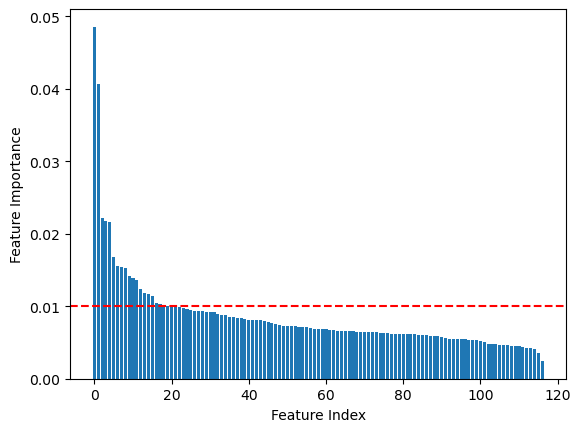

In [37]:
# Feature Selection with Random forest for the best classifier
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=25)

X_resampled, y_resampled=oversampler.fit_resample(X_train, y_train)


rf = RandomForestClassifier(n_estimators=1000,random_state=16)
rf.fit(X_resampled, y_resampled)
feature_importances = rf.feature_importances_
feature_importances_sorted=sorted(feature_importances,reverse=True)
sorted_index=feature_importances.argsort()[::-1]



# Plot feature importance scores
fig, ax = plt.subplots()
ax.bar(range(len(feature_importances_sorted)), feature_importances_sorted)
ax.axhline(y=0.01, color='red', linestyle='--', label='Horizontal Line at 0.01')

plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()




In [45]:
print('number of features with importance greater than 0.01:  '+str(sum(feature_importances>=0.01)))

number of features with importance greater than 0.01:  21


In [33]:
# selecting The number of features based on elbow method and removing every feature with importance lower than 0.01

selected_features_indices=sorted_index[:21]


X_train_selected_features = X_resampled.iloc[:, selected_features_indices]
X_test_selected_features=X_test.iloc[:, selected_features_indices]        

xgb=XGBClassifier(subsample= 0.9, scale_pos_weight= 2, reg_lambda= 1.1, reg_alpha= 0,\
                  n_estimators= 100, min_child_weight= 1, max_depth= 5, learning_rate= 0.2,\
                  gamma= 0.1, colsample_bytree= 1.0)


xgb.fit(X_train_selected_features,y_resampled)
y_predicted=xgb.predict(X_test_selected_features)

print(classification_report(y_test,y_predicted))

# Feature selection initial results were not impressive and did not improve the model. 



              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81        78
         1.0       0.32      0.33      0.33        21

    accuracy                           0.71        99
   macro avg       0.57      0.57      0.57        99
weighted avg       0.71      0.71      0.71        99



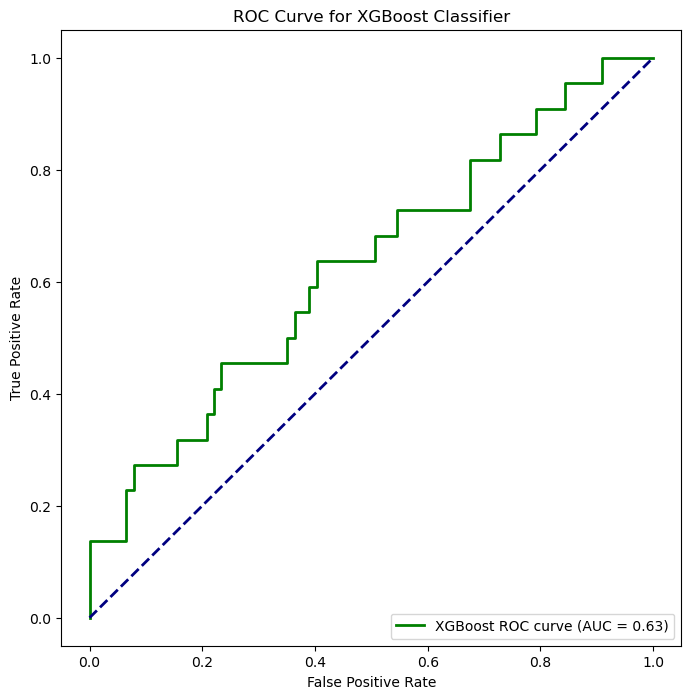

In [92]:
# Plotting ROC Curve for the best model
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=21)
xgb=XGBClassifier(subsample= 0.9, scale_pos_weight= 2, reg_lambda= 1.1, reg_alpha= 0,\
                  n_estimators= 100, min_child_weight= 1, max_depth= 5, learning_rate= 0.2,\
                  gamma= 0.1, colsample_bytree= 1.0,random_state=25)

X_resampled, y_resampled=oversampler.fit_resample(X_train, y_train)

xgb.fit(X_resampled,y_resampled)

y_prob =xgb.predict_proba(X_test)[:, 1]

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob)
roc_auc = auc(fpr_xgb, tpr_xgb)


plt.figure(figsize=(8, 8))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()

In [94]:
# Save the model

import joblib

bestclassifier=XGBClassifier(subsample= 0.9, scale_pos_weight= 2, reg_lambda= 1.1, reg_alpha= 0,\
                  n_estimators= 100, min_child_weight= 1, max_depth= 5, learning_rate= 0.2,\
                  gamma= 0.1, colsample_bytree= 1.0,random_state=25)


X_resampled, y_resampled=oversampler.fit_resample(X, y)

bestclassifier.fit(X_resampled, y_resampled)


model_filename = "final_model_classification.model"
joblib.dump(bestclassifier, model_filename)





['final_model_classification.model']

In [95]:
# Save the Imputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X)

# Save the imputer
imputer_filename = "imputer_model.joblib"
joblib.dump(imputer, imputer_filename)

['imputer_model.joblib']